# Logits to Categorical Distribution

In [2]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.special import softmax

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions import MultivariateNormal

from utils.visualization import plot_prob_simplex, plot_cal_regions_ternary
from ternary.helpers import project_sequence

In [3]:
%matplotlib inline
plt.ioff()

In [4]:
PI = torch.Tensor([math.pi])
n_layers = 5  # Layers to monitor
epochs = 20000

save = False
save_path = r"C:\Users\sergi\Google Drive\calibration-ml\ongoing\logits2categorical"
dev = torch.device('cpu')

# Simulated data
n_samples = 1500
dim = 3

In [5]:
def create_animation_logits(intermediate_results, target):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    sc = ax.scatter(preds[:, 0], preds[:, 1], preds[:, 2], c=target)

    # manually relim:
    xmin = 1e7; xmax = 1e-7;
    ymin = 1e7; ymax = 1e-7;
    zmin = 1e7; zmax = 1e-7;
    for preds in intermediate_results:
        xmin=min(preds[:,0].min(), xmin); xmax=max(preds[:,0].max(), xmax)
        ymin=min(preds[:,1].min(), ymin); ymax=max(preds[:,1].max(), ymax)
        zmin=min(preds[:,2].min(), zmin); zmax=max(preds[:,2].max(), zmax)

    xmin = max(xmin, -10.); xmax = min(xmax, 10.)
    ymin = max(xmin, -10.); ymax = min(ymax, 10.)
    zmin = max(xmin, -10.); zmax = min(zmax, 10.)

    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        sc._offsets3d = (preds[:, 0], preds[:, 1], preds[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [6]:
def create_animation_probs3d(intermediate_results, target):
    
    preds = intermediate_results[0]
    
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(20, 45)

    probs = softmax(intermediate_results[0], 1)
    
    sc = ax.scatter(probs[:, 0], probs[:, 1], probs[:, 2], c=target)

    xmin = -0.1; xmax = 1.1
    ymin = -0.1; ymax = 1.1
    zmin = -0.1; zmax = 1.1
    
    ax.set_xlim(xmin-0.1*(xmax-xmin),xmax+0.1*(xmax-xmin))
    ax.set_ylim(ymin-0.1*(ymax-ymin),ymax+0.1*(ymax-ymin))
    ax.set_zlim(zmin-0.1*(zmax-zmin),zmax+0.1*(zmax-zmin))

    def update_scat(i):
        preds = intermediate_results[i]
        
        probs = softmax(preds, 1)
        sc._offsets3d = (probs[:, 0], probs[:, 1], probs[:, 2])

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [7]:
def create_animation_simplex(intermediate_results, target):
    
    fig, ax = plt.subplots()
    
    probs = softmax(intermediate_results[0], 1)
    
    ax = plot_prob_simplex(probs, target, ax=ax, title='Output probabilities')
    
    def update_scat(i):
        probs = softmax(intermediate_results[i], 1)
        for j, collection in enumerate(ax.ax.collections):
            collection.set_offsets(np.array(project_sequence(probs[target==j])).T)
        ax._redraw_labels()

    ani = animation.FuncAnimation(fig, update_scat, frames=len(intermediate_results), interval=30)
    plt.close(fig)
    
    return ani

In [8]:
def create_animations(intermediate_results, target, save=False, path='', name='animation'):
    ani_simplex = create_animation_simplex(intermediate_results, target)
    ani_logits = create_animation_logits(intermediate_results, target)
    ani_probs3d = create_animation_probs3d(intermediate_results, target)
    if save:
        save_path = os.path.join(path, name)
        ani_simplex.save(save_path  + '-simplex.mp4', codec='h264')
        ani_logits.save(save_path  + '-logits.mp4', codec='h264')
        ani_probs3d.save(save_path  + '-probs3d.mp4', codec='h264')
    return ani_simplex, ani_logits, ani_probs3d

In [9]:
def plot_history(h, save=False, name='history'):
    # Plot training NLL
    fig, ax = plt.subplots(1, 5, figsize=(20, 5))

    ax[0].plot(h['loss'])
    ax[1].plot(h['logpz'])
    ax[2].plot(h['logdet'])
    ax[3].plot(np.array(h['logits_mean']))
    ax[4].plot(np.array(h['logits_size']))


    ax[0].set_title('Training Loss')
    ax[0].set_ylabel(r'$-log(P(z)) - log(Det)$')
    ax[0].set_xlabel('Epoch')

    ax[1].set_title('Log Probability')
    ax[1].set_ylabel(r'$log(P(z))$')
    ax[1].set_xlabel('Epoch')

    ax[2].set_title('Log Determinant')
    ax[2].set_ylabel(r'$log(Det)$')
    ax[2].set_xlabel('Epoch')

    ax[3].set_title('Mean value of output')
    ax[3].set_xlabel('Epoch')
    ax[3].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])

    ax[4].set_title('Mean norm of centered output')
    ax[4].set_xlabel('Epoch')
    ax[4].legend(['Layer: {}'.format(i+1) for i in range(0, len(h['model'].layers), len(h['model'].layers)//n_layers)])

    plt.show(fig)
    
    if save:
        fig.savefig(os.path.join(save_path, name) + '-train.png', dpi=300)

In [10]:
def nll(probs, target):
    return np.mean(-np.log(probs[np.arange(probs.shape[0]), target]))

## Base distributions of uncalibrated logits

* Separable case
* Mixed case

### Separable

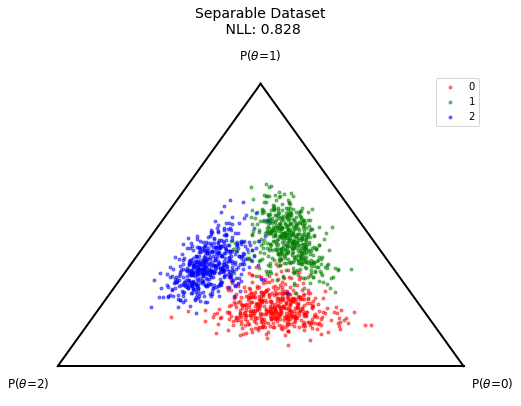

In [11]:
easy_target = np.array(random.choices(range(3), k=n_samples))
easy_one_hot = np.zeros((n_samples, 3))
easy_one_hot[np.arange(n_samples), easy_target] = 1.

# Shift
offset = np.zeros((n_samples, 3))
offset[:, 1:] = 0.05

# Twist
twisting = np.zeros((n_samples, 3))
twisting[np.arange(n_samples), easy_target-1] = 0.7 + np.random.randn(n_samples)*0.1

easy_logits = np.float32(0.8 * (easy_one_hot + twisting + np.random.randn(n_samples, 3)*0.3) + offset)

# Equivalent to log(softmax())
easy_logits -= np.log(np.sum(np.exp(easy_logits), axis=1, keepdims=True))

easy_probs = softmax(easy_logits, axis=1)

# Convert data to torch tensors.
torch_easy_logits = torch.as_tensor(easy_logits, dtype=torch.float)
torch_easy_target = torch.as_tensor(easy_one_hot, dtype=torch.long)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(easy_probs, easy_target, ax=ax, title='Separable Dataset\n NLL: {:.3f}'.format(nll(easy_probs, easy_target)))

plt.show(fig)

### Mixed

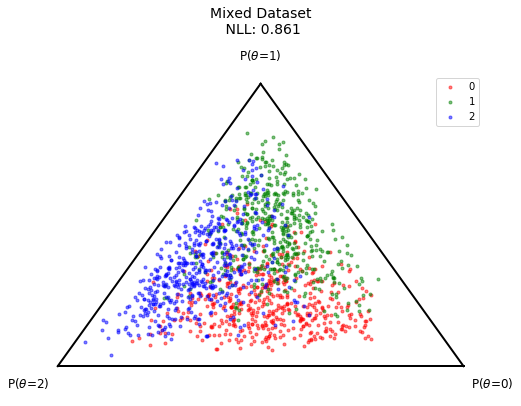

In [12]:
hard_target = np.array(random.choices(range(dim), k=n_samples))
hard_one_hot = np.zeros((n_samples, dim))
hard_one_hot[np.arange(n_samples), hard_target] = 1.

# Shift
offset = np.zeros((n_samples, dim))
offset[:, 1:] = 0.2

# Twist
twisting = np.zeros((n_samples, dim))
twisting[np.arange(n_samples), hard_target-1] = 0.6 + np.random.randn(n_samples)*0.3

hard_logits = np.float32(0.8 * (hard_one_hot + twisting + np.random.randn(n_samples, dim)*0.6) + offset)

# Equivalent to log(softmax())
hard_logits -= np.log(np.sum(np.exp(hard_logits), axis=1, keepdims=True))

hard_probs = softmax(hard_logits, axis=1)

# Convert data to torch tensors.
torch_hard_logits = torch.as_tensor(hard_logits, dtype=torch.float)
torch_hard_target = torch.as_tensor(hard_one_hot, dtype=torch.long)

fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(hard_probs, hard_target, ax=ax, title='Mixed Dataset\n NLL: {:.3f}'.format(nll(hard_probs, hard_target)))

plt.show(fig)

## Baselines: Temp-Scaling and expressive DNN

### Temp-Scaling

In [24]:
class TempScal(nn.Module):
    def __init__(self):
        super(TempScal, self).__init__()
        self.softmx = nn.Softmax(dim=1)
        self.T = torch.nn.Parameter(torch.ones(1), requires_grad=True)
        
    def forward(self, x):
        return self.softmx(x/self.T)

In [28]:
# Train temp-scaling in separable case
temp_model_easy = TempScal()
optim = torch.optim.Adam(temp_model_easy.parameters())
loss = []
intermediate_results = []
for e in range(1500):
    optim.zero_grad()
    
    probs = temp_model_easy(torch_easy_logits)
    _loss = -torch.mean(torch.sum(torch_easy_target*torch.log(probs), dim=1))
    
    _loss.backward()
    optim.step()
    loss.append(_loss.item())
    if e%10 == 0:
        intermediate_results.append(np.log(probs.detach().numpy()))

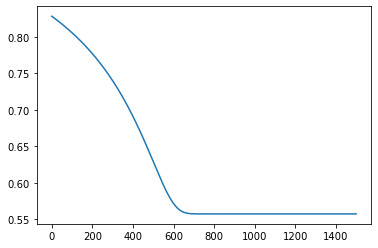

In [29]:
plt.plot(loss)
plt.show()

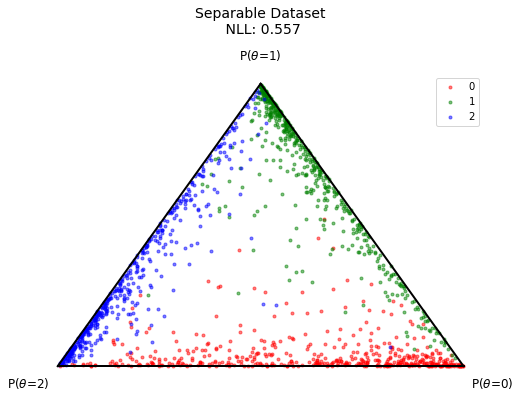

In [30]:
fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(probs.detach().numpy(), easy_target, ax=ax, title='Separable Dataset\n NLL: {:.3f}'.format(nll(probs.detach().numpy(), easy_target)))

plt.show(fig)

In [33]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    intermediate_results, 
    easy_target, 
    save=False, 
    path=save_path, 
    name='')

In [34]:
HTML(ani_simplex.to_html5_video())

In [21]:
# Train temp-scaling in mixed case
temp_model_hard = TempScal()
optim = torch.optim.Adam(temp_model_hard.parameters())
loss = []
intermediate_results = []
for e in range(2000):
    optim.zero_grad()
    
    probs = temp_model_hard(torch_hard_logits)
    _loss = -torch.mean(torch.sum(torch_hard_target*torch.log(probs), dim=1))
    
    _loss.backward()
    optim.step()
    loss.append(_loss.item())
    if e%10 == 0:
        intermediate_results.append(np.log(probs.detach.numpy()))

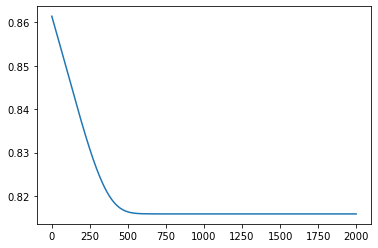

In [22]:
plt.plot(loss)
plt.show()

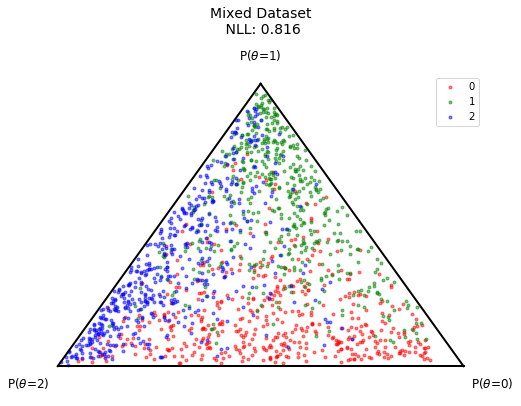

In [23]:
fig, ax = plt.subplots(figsize=(8,6))

ax = plot_prob_simplex(probs.detach().numpy(), hard_target, ax=ax, title='Mixed Dataset\n NLL: {:.3f}'.format(nll(probs.detach().numpy(), hard_target)))

plt.show(fig)

## Define Flows

In [40]:
class MLP(nn.Module):
    def __init__(self, dim, hidden_size=[], activation=F.relu):
        super(MLP, self).__init__()
        self.activation = activation
        units = [dim] + hidden_size + [dim]
        self.layers = nn.ModuleList([nn.Linear(units[i], units[i+1])
                                     for i in range(len(units)-1)])

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        y = self.layers[-1](x)

        return y

In [41]:
class AffineConstantLayer(nn.Module):

    def __init__(self, dim, scale=True, shift=True):
        super(AffineConstantLayer, self).__init__()

        self.s = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if scale else None
        self.t = nn.Parameter(torch.randn(1, dim, requires_grad=True)) \
            if shift else None

    def forward(self, x):
        s = self.s if self.s is not None else x.new_zeros(x.size())
        t = self.t if self.t is not None else x.new_zeros(x.size())
        z = x * torch.exp(s) + t
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def backward(self, z):
        s = self.s if self.s is not None else z.new_zeros(z.size())
        t = self.t if self.t is not None else z.new_zeros(z.size())
        x = (z - t) * torch.exp(-s)
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [42]:
class NvpCouplingLayer(nn.Module):
    def __init__(self, dim, hidden_size=[5, 5], random_mask=True, max_abs=None, scale=True, shift=True):
        super(NvpCouplingLayer, self).__init__()
        self.s = MLP(dim, hidden_size) if scale else lambda x: x.new_zeros(x.size())
        self.t = MLP(dim, hidden_size) if shift else lambda x: x.new_zeros(x.size())
        
        # Use random partitioning of the data
        mask = np.random.randint(2, size=dim)
        if random_mask:
            while mask.sum() < 1 or mask.sum() == dim:
                mask = np.random.randint(2, size=dim)
        else:
            mask = np.zeros((1, dim))
            mask[:, dim//2:] = 1
            
        self.mask = nn.Parameter(
                torch.as_tensor(mask.copy(), dtype=torch.float),
                requires_grad=False)
        
        self.max_abs = max_abs

    def forward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1 * (x * torch.exp(s) + t)

        log_det = torch.sum(b_1*s, dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

    def backward(self, x):
        x_b = self.mask*x
        b_1 = 1 - self.mask

        s, t = self.s(x_b), self.t(x_b)
        y = x_b + b_1*((x - t) * torch.exp(-s))

        log_det = torch.sum(b_1*(-s), dim=1).squeeze()
        
        if self.max_abs is not None:
            log_det -= torch.clamp(torch.abs(torch.sum(y, dim=1)), min=self.max_abs)

        return y.flip((1,)), log_det

In [43]:
class Flow(nn.Module):
    def __init__(self, layers, **kwargs):
        super(Flow, self).__init__()

        self.layers = nn.ModuleList(layers)
        self.log_det = nn.Parameter(torch.zeros(1), requires_grad=False)

    def forward(self, x):
        cum_log_det = self.log_det.new_full((x.shape[0],), fill_value=0)
        zs = []
        for layer in self.layers:
            x, log_det = layer(x)
            zs.append(x)
            cum_log_det += log_det
            
        return zs, cum_log_det
            
    def backward(self, z):
        cum_log_det = self.log_det.new_full((z.shape[0],), fill_value=0)
        xs = []
        for layer in self.layers[::-1]:
            z, log_det = layer.backward(z)
            xs.append(z)
            cum_log_det += log_det

        return xs, cum_log_det

## Train Functions

In [54]:
def get_NICEmodel():
     return Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False, scale=False) for _ in range(10)])

In [55]:
def get_NVPmodel():
     return Flow(layers=[NvpCouplingLayer(dim, [5, 5], random_mask=False) for _ in range(10)])

In [56]:
def train_model(model, epochs, logits, target, loss_function, optimizer=None, dev=torch.device('cpu')):
    model = model.to(dev, non_blocking=True)
    
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    
    softmx = nn.Softmax(dim=1)

    loss = []
    logpz = []
    logdet = []

    # Output at some layers
    logits_mean = []
    logits_size = []
    intermediate_results = []

    # Train loop
    t0 = time.time()
    for e in range(epochs):

        cum_loss = torch.zeros(1, device=dev)
        cum_logdet = torch.zeros(1, device=dev)
        cum_logprior = torch.zeros(1, device=dev)

        optimizer.zero_grad()

        zs, _logdet = model(logits)
        preds = zs[-1]

        _probs = softmx(preds)
        if (preds != preds).any():
            print('Nan in output probabilities, aborting training at epoch: {}'.format(e))
            break

        means = []
        sizes = []
        for i in range(0, len(model.layers), len(model.layers)//n_layers):
            z = zs[i].detach().numpy()
            means.append(np.mean(z))
            sizes.append(np.mean(np.linalg.norm(z-np.mean(z, axis=1, keepdims=True), axis=1)))

        _loss = loss_function(zs, _logdet, target)
            
        _logdet = torch.mean(_logdet)
        _logpz = torch.mean(torch.sum(target*torch.log(_probs), dim=1))


        _loss.backward()
        optimizer.step()

        loss.append(_loss.item())
        logpz.append(_logpz.item())
        logdet.append(_logdet.item())

        logits_mean.append(means)
        logits_size.append(sizes)

        if e%10 == 9:
            print('epoch: {}, at time: {:.2f}, loss: {:.3f}, log(pz): {:.3f}'.format(e, time.time()-t0, loss[-1], logpz[-1])
                  + ', log(det): {:.3f}, mean(logits): {:.3f}, size(logits): {:.3f}'.format(logdet[-1],
                                                                                            np.mean(np.array(logits_mean[-1])),
                                                                                            np.mean(np.array(logits_size[-1])))
                 )
            intermediate_results.append(preds.detach().numpy())
            
    return {'model': model,
            'loss': loss,
            'logpz': logpz,
            'logdet': logdet,
            'logits_mean': logits_mean,
            'logits_size': logits_size,
            'intermediate_results': intermediate_results,
           }

In [57]:
def label_smoothing(onehot, alpha=1):
    target = (onehot*(np.sum(onehot, axis=0) + alpha) + (1-onehot)*alpha)/(np.sum(onehot, axis=0, keepdims=True) + dim*alpha)
    return target

## NVP-like Inverse determinant

In [66]:
# Instantiate model and optimizer
model = get_NVPmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

name='inverse-det'

In [67]:
softmx = nn.Softmax(dim=1)


def loss_inv_det_func(zs, _logdet, target):
    preds = zs[-1]
    _probs = softmx(preds)
    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.sum(target*torch.log(_probs), dim=1))
    
    _loss = -_logpz + _logdet
    
    return _loss

In [68]:
h = train_model(model, epochs, torch_hard_logits, torch_hard_logits, loss_inv_det_func, optimizer=optimizer, dev=dev)

epoch: 9, at time: 0.47, loss: -5.896, log(pz): 7.598, log(det): 1.702, mean(logits): -1.203, size(logits): 1.239
epoch: 19, at time: 1.13, loss: -5.971, log(pz): 7.669, log(det): 1.697, mean(logits): -1.208, size(logits): 1.242
epoch: 29, at time: 1.72, loss: -6.053, log(pz): 7.745, log(det): 1.692, mean(logits): -1.213, size(logits): 1.245
epoch: 39, at time: 2.29, loss: -6.142, log(pz): 7.827, log(det): 1.685, mean(logits): -1.218, size(logits): 1.249
epoch: 49, at time: 2.92, loss: -6.240, log(pz): 7.918, log(det): 1.678, mean(logits): -1.224, size(logits): 1.254
epoch: 59, at time: 3.41, loss: -6.347, log(pz): 8.016, log(det): 1.669, mean(logits): -1.230, size(logits): 1.260
epoch: 69, at time: 4.03, loss: -6.464, log(pz): 8.124, log(det): 1.660, mean(logits): -1.237, size(logits): 1.267
epoch: 79, at time: 4.65, loss: -6.591, log(pz): 8.241, log(det): 1.649, mean(logits): -1.244, size(logits): 1.275
epoch: 89, at time: 5.24, loss: -6.730, log(pz): 8.368, log(det): 1.638, mean(log

epoch: 709, at time: 44.80, loss: -66.462, log(pz): 66.477, log(det): 0.015, mean(logits): -3.312, size(logits): 7.547
epoch: 719, at time: 45.41, loss: -71.466, log(pz): 71.398, log(det): -0.067, mean(logits): -3.466, size(logits): 8.013
Nan in output probabilities, aborting training at epoch: 727


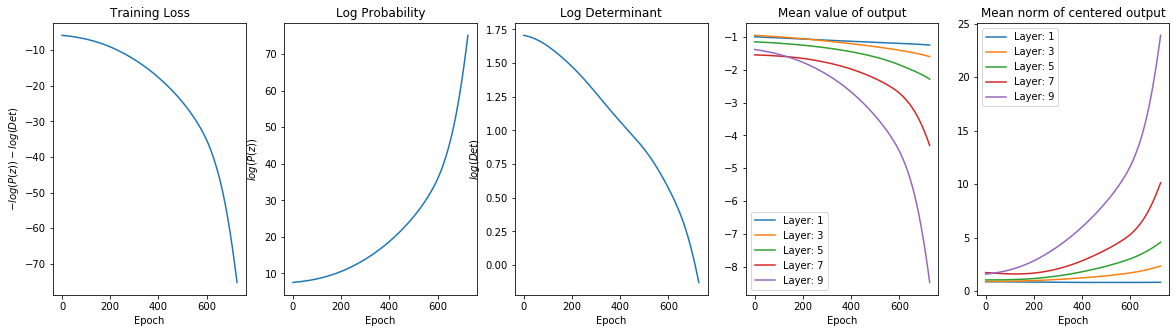

In [69]:
plot_history(h, save=save, name=name)

In [70]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h['intermediate_results'], 
    easy_target, 
    save=save, 
    path=save_path, 
    name=name)

In [71]:
HTML(ani_simplex.to_html5_video())

In [72]:
HTML(ani_logits.to_html5_video())

## NVP-like flow separable case, laplace smoothing

In [20]:
alpha = 100  # smoothing parameter

In [21]:
# Instantiate model and optimizer
model = get_NVPmodel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

name='laplacea{:d}-separable'.format(alpha)

In [22]:
softmx = nn.Softmax(dim=1)


target = label_smoothing(easy_one_hot, alpha)
torch_easy_target = torch.tensor(target, device=dev)

def loss_laplace_func(zs, _logdet, target):
    preds = zs[-1]
    _probs = softmx(preds)
    _logdet = torch.mean(_logdet)
    _logpz = torch.mean(torch.sum(target*torch.log(_probs), dim=1))
    
    _loss = -_logpz - _logdet
    
    return _loss

In [23]:
h = train_model(model, epochs, torch_easy_logits, torch_easy_target, loss_laplace_func, optimizer=optimizer, dev=dev)

epoch: 9, at time: 0.61, loss: 1.192, log(pz): -0.954, log(det): -0.238, mean(logits): -1.452, size(logits): 0.926
epoch: 19, at time: 1.27, loss: 1.187, log(pz): -0.953, log(det): -0.234, mean(logits): -1.453, size(logits): 0.927
epoch: 29, at time: 1.97, loss: 1.183, log(pz): -0.953, log(det): -0.230, mean(logits): -1.454, size(logits): 0.928
epoch: 39, at time: 2.69, loss: 1.179, log(pz): -0.953, log(det): -0.226, mean(logits): -1.455, size(logits): 0.929
epoch: 49, at time: 3.43, loss: 1.174, log(pz): -0.952, log(det): -0.222, mean(logits): -1.456, size(logits): 0.930
epoch: 59, at time: 4.14, loss: 1.170, log(pz): -0.952, log(det): -0.218, mean(logits): -1.456, size(logits): 0.931
epoch: 69, at time: 4.86, loss: 1.166, log(pz): -0.952, log(det): -0.214, mean(logits): -1.457, size(logits): 0.931
epoch: 79, at time: 5.52, loss: 1.161, log(pz): -0.952, log(det): -0.210, mean(logits): -1.458, size(logits): 0.932
epoch: 89, at time: 6.19, loss: 1.157, log(pz): -0.951, log(det): -0.206,

epoch: 709, at time: 50.59, loss: 0.890, log(pz): -0.935, log(det): 0.046, mean(logits): -1.514, size(logits): 0.994
epoch: 719, at time: 51.33, loss: 0.885, log(pz): -0.935, log(det): 0.050, mean(logits): -1.515, size(logits): 0.995
epoch: 729, at time: 52.06, loss: 0.881, log(pz): -0.935, log(det): 0.054, mean(logits): -1.516, size(logits): 0.996
epoch: 739, at time: 52.72, loss: 0.877, log(pz): -0.935, log(det): 0.058, mean(logits): -1.517, size(logits): 0.997
epoch: 749, at time: 53.43, loss: 0.872, log(pz): -0.934, log(det): 0.062, mean(logits): -1.517, size(logits): 0.998
epoch: 759, at time: 54.14, loss: 0.868, log(pz): -0.934, log(det): 0.066, mean(logits): -1.518, size(logits): 0.999
epoch: 769, at time: 54.84, loss: 0.864, log(pz): -0.934, log(det): 0.070, mean(logits): -1.519, size(logits): 1.000
epoch: 779, at time: 55.52, loss: 0.859, log(pz): -0.934, log(det): 0.074, mean(logits): -1.520, size(logits): 1.001
epoch: 789, at time: 56.24, loss: 0.855, log(pz): -0.934, log(de

epoch: 1409, at time: 102.09, loss: 0.586, log(pz): -0.921, log(det): 0.334, mean(logits): -1.582, size(logits): 1.072
epoch: 1419, at time: 102.78, loss: 0.582, log(pz): -0.921, log(det): 0.339, mean(logits): -1.583, size(logits): 1.073
epoch: 1429, at time: 103.50, loss: 0.578, log(pz): -0.920, log(det): 0.343, mean(logits): -1.584, size(logits): 1.074
epoch: 1439, at time: 104.22, loss: 0.573, log(pz): -0.920, log(det): 0.347, mean(logits): -1.585, size(logits): 1.075
epoch: 1449, at time: 104.92, loss: 0.569, log(pz): -0.920, log(det): 0.351, mean(logits): -1.586, size(logits): 1.076
epoch: 1459, at time: 105.63, loss: 0.564, log(pz): -0.920, log(det): 0.355, mean(logits): -1.587, size(logits): 1.078
epoch: 1469, at time: 106.32, loss: 0.560, log(pz): -0.920, log(det): 0.360, mean(logits): -1.588, size(logits): 1.079
epoch: 1479, at time: 107.03, loss: 0.556, log(pz): -0.919, log(det): 0.364, mean(logits): -1.589, size(logits): 1.080
epoch: 1489, at time: 107.71, loss: 0.551, log(p

epoch: 2099, at time: 151.24, loss: 0.275, log(pz): -0.909, log(det): 0.634, mean(logits): -1.662, size(logits): 1.160
epoch: 2109, at time: 151.97, loss: 0.271, log(pz): -0.909, log(det): 0.638, mean(logits): -1.663, size(logits): 1.161
epoch: 2119, at time: 152.71, loss: 0.266, log(pz): -0.909, log(det): 0.643, mean(logits): -1.664, size(logits): 1.163
epoch: 2129, at time: 153.45, loss: 0.261, log(pz): -0.909, log(det): 0.647, mean(logits): -1.666, size(logits): 1.164
epoch: 2139, at time: 154.19, loss: 0.257, log(pz): -0.908, log(det): 0.652, mean(logits): -1.667, size(logits): 1.165
epoch: 2149, at time: 154.91, loss: 0.252, log(pz): -0.908, log(det): 0.656, mean(logits): -1.668, size(logits): 1.167
epoch: 2159, at time: 155.64, loss: 0.247, log(pz): -0.908, log(det): 0.661, mean(logits): -1.669, size(logits): 1.168
epoch: 2169, at time: 156.38, loss: 0.243, log(pz): -0.908, log(det): 0.665, mean(logits): -1.671, size(logits): 1.170
epoch: 2179, at time: 157.12, loss: 0.238, log(p

epoch: 2789, at time: 200.52, loss: -0.050, log(pz): -0.901, log(det): 0.951, mean(logits): -1.761, size(logits): 1.267
epoch: 2799, at time: 201.22, loss: -0.055, log(pz): -0.901, log(det): 0.956, mean(logits): -1.762, size(logits): 1.269
epoch: 2809, at time: 201.91, loss: -0.060, log(pz): -0.901, log(det): 0.961, mean(logits): -1.764, size(logits): 1.270
epoch: 2819, at time: 202.61, loss: -0.065, log(pz): -0.901, log(det): 0.965, mean(logits): -1.766, size(logits): 1.272
epoch: 2829, at time: 203.32, loss: -0.069, log(pz): -0.901, log(det): 0.970, mean(logits): -1.767, size(logits): 1.274
epoch: 2839, at time: 204.04, loss: -0.074, log(pz): -0.901, log(det): 0.975, mean(logits): -1.769, size(logits): 1.276
epoch: 2849, at time: 204.76, loss: -0.079, log(pz): -0.901, log(det): 0.980, mean(logits): -1.771, size(logits): 1.277
epoch: 2859, at time: 205.45, loss: -0.084, log(pz): -0.901, log(det): 0.984, mean(logits): -1.772, size(logits): 1.279
epoch: 2869, at time: 206.15, loss: -0.0

epoch: 3479, at time: 249.39, loss: -0.387, log(pz): -0.900, log(det): 1.288, mean(logits): -1.890, size(logits): 1.406
epoch: 3489, at time: 250.11, loss: -0.392, log(pz): -0.900, log(det): 1.293, mean(logits): -1.892, size(logits): 1.408
epoch: 3499, at time: 250.80, loss: -0.397, log(pz): -0.900, log(det): 1.298, mean(logits): -1.894, size(logits): 1.410
epoch: 3509, at time: 251.53, loss: -0.402, log(pz): -0.900, log(det): 1.303, mean(logits): -1.896, size(logits): 1.413
epoch: 3519, at time: 252.22, loss: -0.407, log(pz): -0.901, log(det): 1.308, mean(logits): -1.898, size(logits): 1.415
epoch: 3529, at time: 252.93, loss: -0.412, log(pz): -0.901, log(det): 1.313, mean(logits): -1.900, size(logits): 1.417
epoch: 3539, at time: 253.59, loss: -0.417, log(pz): -0.901, log(det): 1.318, mean(logits): -1.903, size(logits): 1.420
epoch: 3549, at time: 254.30, loss: -0.422, log(pz): -0.901, log(det): 1.323, mean(logits): -1.905, size(logits): 1.422
epoch: 3559, at time: 254.98, loss: -0.4

epoch: 4169, at time: 297.40, loss: -0.733, log(pz): -0.912, log(det): 1.646, mean(logits): -2.053, size(logits): 1.588
epoch: 4179, at time: 298.12, loss: -0.738, log(pz): -0.913, log(det): 1.651, mean(logits): -2.055, size(logits): 1.591
epoch: 4189, at time: 298.83, loss: -0.743, log(pz): -0.913, log(det): 1.656, mean(logits): -2.058, size(logits): 1.594
epoch: 4199, at time: 299.60, loss: -0.748, log(pz): -0.913, log(det): 1.662, mean(logits): -2.060, size(logits): 1.597
epoch: 4209, at time: 300.41, loss: -0.753, log(pz): -0.914, log(det): 1.667, mean(logits): -2.063, size(logits): 1.600
epoch: 4219, at time: 301.21, loss: -0.758, log(pz): -0.914, log(det): 1.672, mean(logits): -2.066, size(logits): 1.603
epoch: 4229, at time: 302.04, loss: -0.763, log(pz): -0.914, log(det): 1.678, mean(logits): -2.068, size(logits): 1.606
epoch: 4239, at time: 302.83, loss: -0.768, log(pz): -0.915, log(det): 1.683, mean(logits): -2.071, size(logits): 1.609
epoch: 4249, at time: 303.66, loss: -0.7

epoch: 4859, at time: 344.52, loss: -1.078, log(pz): -0.945, log(det): 2.023, mean(logits): -2.247, size(logits): 1.816
epoch: 4869, at time: 345.19, loss: -1.083, log(pz): -0.946, log(det): 2.029, mean(logits): -2.250, size(logits): 1.819
epoch: 4879, at time: 345.88, loss: -1.088, log(pz): -0.947, log(det): 2.034, mean(logits): -2.253, size(logits): 1.823
epoch: 4889, at time: 346.61, loss: -1.093, log(pz): -0.947, log(det): 2.040, mean(logits): -2.256, size(logits): 1.827
epoch: 4899, at time: 347.30, loss: -1.097, log(pz): -0.948, log(det): 2.045, mean(logits): -2.259, size(logits): 1.830
epoch: 4909, at time: 347.96, loss: -1.102, log(pz): -0.949, log(det): 2.051, mean(logits): -2.262, size(logits): 1.834
epoch: 4919, at time: 348.70, loss: -1.107, log(pz): -0.949, log(det): 2.057, mean(logits): -2.265, size(logits): 1.838
epoch: 4929, at time: 349.40, loss: -1.112, log(pz): -0.950, log(det): 2.062, mean(logits): -2.268, size(logits): 1.842
epoch: 4939, at time: 350.11, loss: -1.1

epoch: 5549, at time: 392.00, loss: -1.406, log(pz): -1.003, log(det): 2.409, mean(logits): -2.461, size(logits): 2.082
epoch: 5559, at time: 392.71, loss: -1.411, log(pz): -1.004, log(det): 2.414, mean(logits): -2.464, size(logits): 2.086
epoch: 5569, at time: 393.38, loss: -1.415, log(pz): -1.005, log(det): 2.420, mean(logits): -2.467, size(logits): 2.090
epoch: 5579, at time: 394.05, loss: -1.420, log(pz): -1.005, log(det): 2.425, mean(logits): -2.470, size(logits): 2.094
epoch: 5589, at time: 394.72, loss: -1.424, log(pz): -1.006, log(det): 2.431, mean(logits): -2.473, size(logits): 2.098
epoch: 5599, at time: 395.39, loss: -1.429, log(pz): -1.007, log(det): 2.436, mean(logits): -2.476, size(logits): 2.102
epoch: 5609, at time: 396.04, loss: -1.433, log(pz): -1.008, log(det): 2.442, mean(logits): -2.479, size(logits): 2.106
epoch: 5619, at time: 396.72, loss: -1.438, log(pz): -1.009, log(det): 2.447, mean(logits): -2.482, size(logits): 2.110
epoch: 5629, at time: 397.40, loss: -1.4

epoch: 6239, at time: 438.32, loss: -1.702, log(pz): -1.074, log(det): 2.776, mean(logits): -2.672, size(logits): 2.358
epoch: 6249, at time: 439.04, loss: -1.706, log(pz): -1.075, log(det): 2.781, mean(logits): -2.675, size(logits): 2.362
epoch: 6259, at time: 439.73, loss: -1.710, log(pz): -1.076, log(det): 2.786, mean(logits): -2.678, size(logits): 2.366
epoch: 6269, at time: 440.34, loss: -1.714, log(pz): -1.077, log(det): 2.791, mean(logits): -2.681, size(logits): 2.370
epoch: 6279, at time: 441.00, loss: -1.718, log(pz): -1.079, log(det): 2.797, mean(logits): -2.684, size(logits): 2.374
epoch: 6289, at time: 441.66, loss: -1.722, log(pz): -1.080, log(det): 2.802, mean(logits): -2.687, size(logits): 2.378
epoch: 6299, at time: 442.33, loss: -1.726, log(pz): -1.081, log(det): 2.807, mean(logits): -2.690, size(logits): 2.382
epoch: 6309, at time: 442.99, loss: -1.730, log(pz): -1.082, log(det): 2.812, mean(logits): -2.693, size(logits): 2.386
epoch: 6319, at time: 443.63, loss: -1.7

epoch: 6929, at time: 485.42, loss: -1.965, log(pz): -1.149, log(det): 3.114, mean(logits): -2.880, size(logits): 2.637
epoch: 6939, at time: 486.12, loss: -1.968, log(pz): -1.150, log(det): 3.118, mean(logits): -2.883, size(logits): 2.641
epoch: 6949, at time: 486.79, loss: -1.972, log(pz): -1.151, log(det): 3.123, mean(logits): -2.886, size(logits): 2.645
epoch: 6959, at time: 487.48, loss: -1.976, log(pz): -1.152, log(det): 3.128, mean(logits): -2.889, size(logits): 2.649
epoch: 6969, at time: 488.29, loss: -1.979, log(pz): -1.153, log(det): 3.132, mean(logits): -2.892, size(logits): 2.653
epoch: 6979, at time: 489.03, loss: -1.983, log(pz): -1.154, log(det): 3.137, mean(logits): -2.895, size(logits): 2.657
epoch: 6989, at time: 489.71, loss: -1.986, log(pz): -1.155, log(det): 3.141, mean(logits): -2.898, size(logits): 2.661
epoch: 6999, at time: 490.41, loss: -1.990, log(pz): -1.156, log(det): 3.146, mean(logits): -2.901, size(logits): 2.665
epoch: 7009, at time: 491.07, loss: -1.9

epoch: 7619, at time: 534.74, loss: -2.199, log(pz): -1.219, log(det): 3.418, mean(logits): -3.077, size(logits): 2.908
epoch: 7629, at time: 535.47, loss: -2.203, log(pz): -1.220, log(det): 3.422, mean(logits): -3.080, size(logits): 2.912
epoch: 7639, at time: 536.21, loss: -2.206, log(pz): -1.221, log(det): 3.426, mean(logits): -3.083, size(logits): 2.916
epoch: 7649, at time: 536.88, loss: -2.209, log(pz): -1.222, log(det): 3.431, mean(logits): -3.086, size(logits): 2.920
epoch: 7659, at time: 537.64, loss: -2.212, log(pz): -1.222, log(det): 3.435, mean(logits): -3.088, size(logits): 2.923
epoch: 7669, at time: 538.30, loss: -2.215, log(pz): -1.223, log(det): 3.439, mean(logits): -3.091, size(logits): 2.927
epoch: 7679, at time: 539.05, loss: -2.219, log(pz): -1.224, log(det): 3.443, mean(logits): -3.094, size(logits): 2.931
epoch: 7689, at time: 539.75, loss: -2.222, log(pz): -1.225, log(det): 3.447, mean(logits): -3.097, size(logits): 2.935
epoch: 7699, at time: 540.40, loss: -2.2

epoch: 8309, at time: 583.07, loss: -2.410, log(pz): -1.287, log(det): 3.697, mean(logits): -3.255, size(logits): 3.162
epoch: 8319, at time: 583.76, loss: -2.413, log(pz): -1.288, log(det): 3.700, mean(logits): -3.257, size(logits): 3.166
epoch: 8329, at time: 584.43, loss: -2.415, log(pz): -1.289, log(det): 3.704, mean(logits): -3.259, size(logits): 3.169
epoch: 8339, at time: 585.17, loss: -2.418, log(pz): -1.290, log(det): 3.708, mean(logits): -3.262, size(logits): 3.173
epoch: 8349, at time: 585.90, loss: -2.421, log(pz): -1.291, log(det): 3.712, mean(logits): -3.264, size(logits): 3.176
epoch: 8359, at time: 586.63, loss: -2.424, log(pz): -1.292, log(det): 3.716, mean(logits): -3.266, size(logits): 3.180
epoch: 8369, at time: 587.32, loss: -2.427, log(pz): -1.293, log(det): 3.720, mean(logits): -3.269, size(logits): 3.183
epoch: 8379, at time: 588.03, loss: -2.430, log(pz): -1.294, log(det): 3.723, mean(logits): -3.271, size(logits): 3.187
epoch: 8389, at time: 588.71, loss: -2.4

KeyboardInterrupt: 

In [ ]:
plot_history(h, save=save, name=name)

In [ ]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h['intermediate_results'], 
    easy_target, 
    save=save, 
    path=save_path, 
    name=name)

In [ ]:
HTML(ani_simplex.to_html5_video())

In [ ]:
HTML(ani_logits.to_html5_video())

In [ ]:
HTML(ani_probs3d.to_html5_video())

## NVP-like flow mixed case, laplace smoothing

In [ ]:
name='laplacea{:d}-mixed'.format(alpha)

In [ ]:
# Instantiate model and optimizer
mixed_model = get_NVPmodel()
optimizer = torch.optim.Adam(mixed_model.parameters(), lr=1e-5)

In [ ]:
target = label_smoothing(hard_one_hot, alpha)
torch_hard_target = torch.tensor(target, device=dev)

In [ ]:
h2 = train_model(mixed_model, epochs, torch_hard_logits, torch_hard_target, loss_laplace_func, optimizer=optimizer, dev=dev)

In [ ]:
plot_history(h2, save=save, name=name)

In [ ]:
ani_simplex, ani_logits, ani_probs3d = create_animations(
    h2['intermediate_results'], 
    hard_target, 
    save=save, 
    path=save_path, 
    name=name)

In [ ]:
HTML(ani_simplex.to_html5_video())

In [ ]:
HTML(ani_logits.to_html5_video())

In [ ]:
HTML(ani_probs3d.to_html5_video())